# **IA Avanzada - Entrega Final**

## Preprocesamiento

### *Lectura de Datos*

In [57]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.datasets import cifar10
from keras.utils import to_categorical
import numpy as np
from sklearn.model_selection import train_test_split

# Carga de CIFAR-10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Interesan sólo autos, barcos y camiones
classes_of_interest = [1, 9, 8]

# Crear máscaras booleanas para filtrar las clases de interés
train_mask = np.isin(y_train, classes_of_interest)  # Crea una máscara para datos de entrenamiento
test_mask = np.isin(y_test, classes_of_interest)  # Crea una máscara para datos de prueba

# Aplicar las máscaras a los datos de entrenamiento y prueba
x_train_filtered = x_train[train_mask[:, 0]]  # Aplica la máscara a los datos de entrenamiento
y_train_filtered = y_train[train_mask[:, 0]]  # Aplica la máscara a las etiquetas de entrenamiento
x_test_filtered = x_test[test_mask[:, 0]]  # Aplica la máscara a los datos de prueba
y_test_filtered = y_test[test_mask[:, 0]]  # Aplica la máscara a las etiquetas de prueba



### *Normalización*

In [58]:
# Preprocesamiento de datos
x_train_filtered = x_train_filtered / 255.0  # Normalizar los valores de píxeles en el rango [0, 1]
x_test_filtered = x_test_filtered / 255.0   # Normalizar los valores de píxeles en el rango [0, 1]

# Mapear etiquetas a un rango de 0, 1, 2. Si no, da error
# Crear un diccionario de mapeo de clases
class_mapping = {1: 0, 8: 1, 9: 2}
# Nombres de clases para los gráficos
class_names = ['Auto', 'Barco', 'Camión']

# Aplicar el mapeo a las etiquetas de entrenamiento y prueba
y_train_filtered = np.vectorize(class_mapping.get)(y_train_filtered)
y_test_filtered = np.vectorize(class_mapping.get)(y_test_filtered)

# Juntar todos los datos filtrados por clase
x_combined = np.concatenate([x_train_filtered, x_test_filtered], axis=0)
y_combined = np.concatenate([y_train_filtered, y_test_filtered], axis=0)

### *Separación de datos de Entrenamiento y Validación*

In [59]:
# @title Parámetros
PORCENTAJE_ENTRENAMIENTO = 0.25 # @param {type:"number"}
include_validation = True # @param {type: "boolean"}
if include_validation:
  PORCENTAJE_VALIDACION = 0.15 # @param {type:"number"}
RANDOM_STATE = 42 # @param {type:"number"}

In [60]:
# 25% para test
x_train_final, x_test_final, y_train_final, y_test_final = train_test_split(
    x_combined, y_combined, test_size=PORCENTAJE_ENTRENAMIENTO, random_state=RANDOM_STATE)

# Variables de validación vacías al principio
x_validation_final, y_validation_final = [], []

if include_validation:
    # 15% para validación
    x_train_final, x_validation_final, y_train_final, y_validation_final = train_test_split(
        x_train_final, y_train_final, test_size=PORCENTAJE_VALIDACION, random_state=RANDOM_STATE)

print(f"Número de datos de entrenamiento: {len(x_train_final)}")
print(f"Número de datos de validación: {len(x_validation_final)}")
print(f"Número de datos de testeo: {len(x_test_final)}")

Número de datos de entrenamiento: 11475
Número de datos de validación: 2025
Número de datos de testeo: 4500


### *Data Augmentation*

In [61]:
# @title Parámetros
CAMBIO_MAXIMO_ANCHO_IMAGEN = 0.1 # @param {type:"number"}
CAMBIO_MAXIMO_ALTO_IMAGEN = 0.1 # @param {type:"number"}
RANGO_ROTACION = 10 # @param {type:"number"}
RANGO_ZOOM = 0.1 # @param {type:"number"}
VOLTEAR_HORIZONTAL = True # @param {type:"boolean"}
MODO_RELLENO_TRANSFORMACIONES = "nearest" # @param ["nearest"]
RANDOM_STATE = 42 # @param {type:"number"}

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

# Definir las transformaciones de aumento de datos con una semilla
datagen = ImageDataGenerator(
    rotation_range=RANGO_ROTACION,  # Rango de rotación
    width_shift_range=CAMBIO_MAXIMO_ANCHO_IMAGEN,  # Cambio máximo en el ancho de la imagen (10%)
    height_shift_range=CAMBIO_MAXIMO_ALTO_IMAGEN,  # Cambio máximo en la altura de la imagen (10%)
    zoom_range=RANGO_ZOOM,  # Rango de zoom (10%)
    horizontal_flip=VOLTEAR_HORIZONTAL,  # Volteo horizontal
    fill_mode=MODO_RELLENO_TRANSFORMACIONES  # Modo de relleno para las transformaciones
)

# Preparar el generador de datos aumentados
datagen.fit(x_train_final, augment=True, seed=RANDOM_STATE)

# Definir la cantidad de veces que que se duplican los datos
num_augmented_samples = len(x_train_final)

# Generar datos aumentados
augmented_data = []
for x_batch, y_batch in datagen.flow(x_train_final, y_train_final, batch_size=num_augmented_samples, seed=RANDOM_STATE, shuffle=False):
    augmented_data.append((x_batch, y_batch))
    break

# Combinar los datos originales con los datos aumentados
augmented_x_train, augmented_y_train = augmented_data[0]

# Concatenar el dataset aumentado al dataset final de entrenamiento
x_train_final = np.concatenate([x_train_final, augmented_x_train])
y_train_final = np.concatenate([y_train_final, augmented_y_train])

# Verificar las dimensiones del conjunto de datos final después de aumentar
print(f"Número de datos de entrenamiento después de aumentar: {len(x_train_final)}")

Número de datos de entrenamiento después de aumentar: 22950


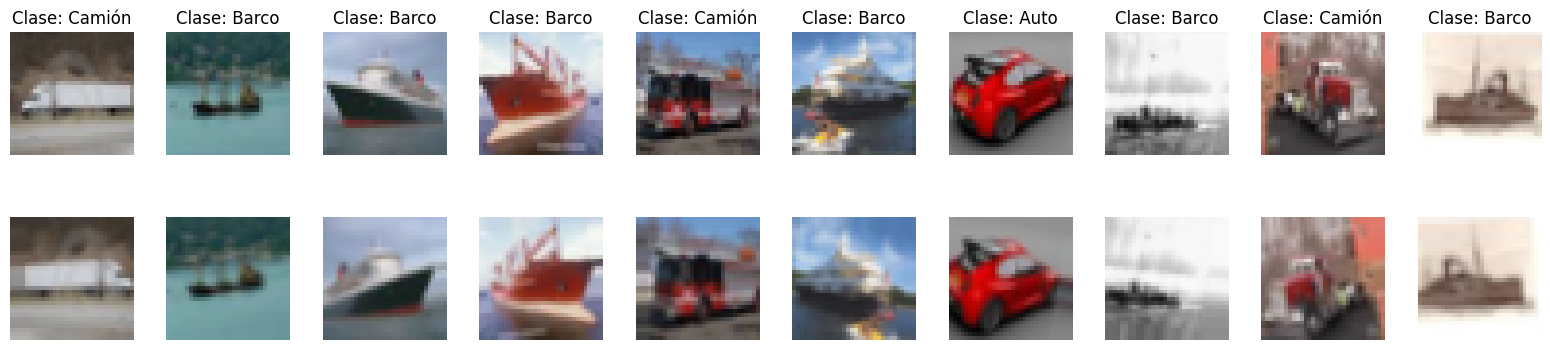

In [63]:
# @title Ejemplos de datos aumentados
CANTIDAD_IMAGENES = 10 # @param {type:"number"}

# Plotear las primeras 10 imágenes del conjunto de datos original y aumentado
fig, axs = plt.subplots(2, CANTIDAD_IMAGENES, figsize=(CANTIDAD_IMAGENES*2, 4))
fig.subplots_adjust(hspace=0.5, wspace=0.1)
plt.suptitle('', fontsize=16)

for i in range(CANTIDAD_IMAGENES):
    # Imágenes originales
    axs[0, i].imshow(x_train_final[i])
    axs[0, i].set_title(f'Clase: {class_names[y_train_final[i][0]]}')
    axs[0, i].axis('off')

    # Imágenes aumentadas
    axs[1, i].imshow(x_train_final[i + len(x_train_final) // 2])
    #axs[1, i].set_title(f'Clase: {class_names[y_train_final[i + len(x_train_final) // 2][0]]}')
    axs[1, i].axis('off')

plt.show()

## Definición del Modelo

In [64]:
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense
from keras.models import Sequential
import sys
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD

# Definir el modelo
def define_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Dropout(0.2))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Dropout(0.2))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Dropout(0.2))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dropout(0.2))
 model.add(Dense(3, activation='softmax'))
 # compile model
 opt = SGD(learning_rate=0.001, momentum=0.9)
 model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
 return model

model = define_model()

### *Resumen de Capas*

In [65]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 64)        36928     
                                                      

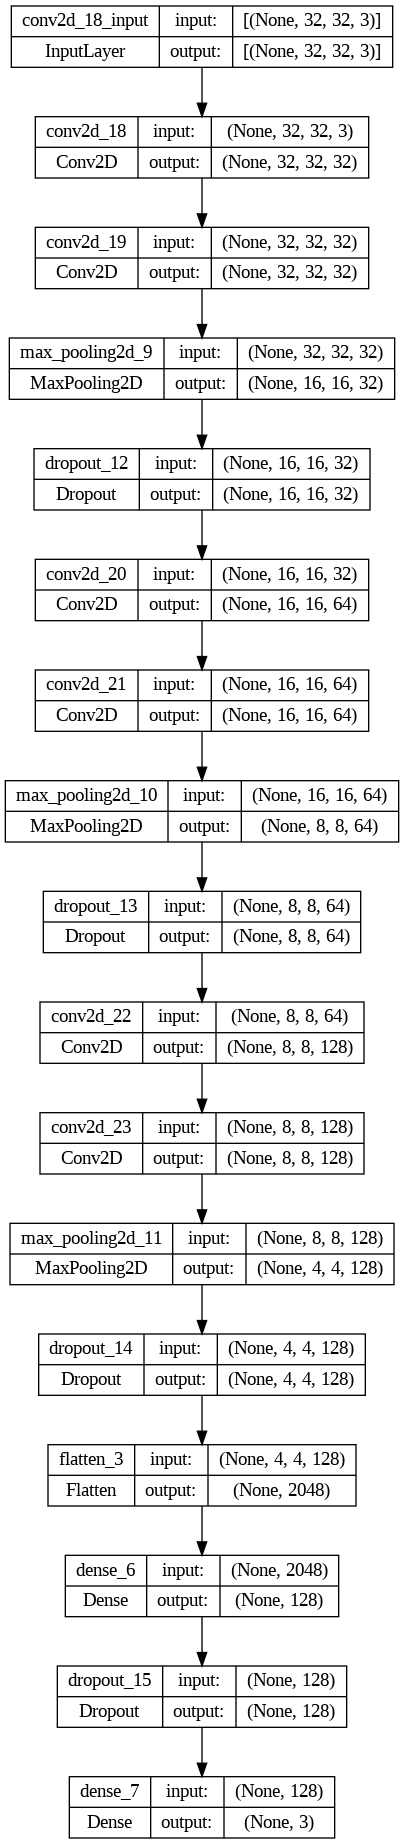

In [66]:
from keras.utils import plot_model
plot_model(model, to_file='modelo.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

## Entrenamiento

In [67]:
# @title Parámetros
MAX_EPOCAS = 100 # @param {type:"integer"}

In [68]:
early = keras.callbacks.EarlyStopping(patience=50, monitor='val_loss',
                                     restore_best_weights=True)

# Entrenamiento del modelo. Guardo en fiteo porque después voy a usar eso para graficar
if include_validation:
    fiteo = model.fit(x_train_final, y_train_final, epochs=MAX_EPOCAS,
                      validation_data=(x_validation_final, y_validation_final), callbacks=[early,])
else:
    fiteo = model.fit(x_train_final, y_train_final, epochs=MAX_EPOCAS, callbacks=[early,])

Epoch 1/100
718/718 [==============================] - 6s 7ms/step - loss: 0.9263 - accuracy: 0.5558 - val_loss: 0.7238 - val_accuracy: 0.6825
Epoch 2/100
718/718 [==============================] - 6s 8ms/step - loss: 0.7409 - accuracy: 0.6699 - val_loss: 0.6075 - val_accuracy: 0.7447
Epoch 3/100
718/718 [==============================] - 5s 7ms/step - loss: 0.6399 - accuracy: 0.7247 - val_loss: 0.5059 - val_accuracy: 0.7931
Epoch 4/100
718/718 [==============================] - 6s 8ms/step - loss: 0.5679 - accuracy: 0.7651 - val_loss: 0.4416 - val_accuracy: 0.8252
Epoch 5/100
718/718 [==============================] - 5s 7ms/step - loss: 0.5146 - accuracy: 0.7919 - val_loss: 0.4316 - val_accuracy: 0.8281
Epoch 6/100
718/718 [==============================] - 7s 10ms/step - loss: 0.4763 - accuracy: 0.8104 - val_loss: 0.3660 - val_accuracy: 0.8612
Epoch 7/100
718/718 [==============================] - 5s 7ms/step - loss: 0.4424 - accuracy: 0.8244 - val_loss: 0.3583 - val_accuracy: 0.855

## Generación de reportes

### *Informes de Métricas*

In [69]:
from sklearn.metrics import classification_report, accuracy_score

# Predecir clases en el conjunto de entrenamiento
y_train_pred = model.predict(x_train_final)
# Convertir las predicciones de entrenamiento en etiquetas de clase
y_train_pred_labels = np.argmax(y_train_pred, axis=1)

# Inicializar las variables de predicción y etiquetas de validación
y_validation_pred, y_validation_pred_labels = None, None

if include_validation:
    y_validation_pred = model.predict(x_validation_final)
    # Convertir las predicciones de validación en etiquetas de clase
    y_validation_pred_labels = np.argmax(y_validation_pred, axis=1)

# Predecir clases en el conjunto de prueba
y_test_pred = model.predict(x_test_final)

# Convertir las predicciones de testeo en etiquetas de clase
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

print("\n==================================================\n")

print("Informe de métricas para el conjunto de entrenamiento:")
train_report = classification_report(y_train_final, y_train_pred_labels, target_names=class_names)
train_accuracy = accuracy_score(y_train_final, y_train_pred_labels)
print(train_report)
print(f"Accuracy Total (Entrenamiento): {train_accuracy:.4f}")

if include_validation:
    print("\n==================================================\n")
    print("Informe de métricas para el conjunto de validación:")
    valid_report = classification_report(y_validation_final, y_validation_pred_labels, target_names=class_names)
    valid_accuracy = accuracy_score(y_validation_final, y_validation_pred_labels)
    print(valid_report)
    print(f"Accuracy Total (Validación): {valid_accuracy:.4f}")
print("\n==================================================\n")

print("Informe de métricas para el conjunto de prueba:")
test_report = classification_report(y_test_final, y_test_pred_labels, target_names=class_names)
test_accuracy = accuracy_score(y_test_final, y_test_pred_labels)
print(test_report)
print(f"Accuracy Total (Prueba): {test_accuracy:.4f}")

141/141 [==============================] - 0s 2ms/step


Informe de métricas para el conjunto de entrenamiento:
              precision    recall  f1-score   support

        Auto       0.98      0.99      0.98      7694
       Barco       0.99      0.99      0.99      7602
      Camión       0.99      0.97      0.98      7654

    accuracy                           0.98     22950
   macro avg       0.98      0.98      0.98     22950
weighted avg       0.98      0.98      0.98     22950

Accuracy Total (Entrenamiento): 0.9845


Informe de métricas para el conjunto de validación:
              precision    recall  f1-score   support

        Auto       0.93      0.95      0.94       662
       Barco       0.97      0.95      0.96       691
      Camión       0.94      0.94      0.94       672

    accuracy                           0.95      2025
   macro avg       0.95      0.95      0.95      2025
weighted avg       0.95      0.95      0.95      2025

Accuracy Total (Validación): 0.94

### *Matrices de Confusión*

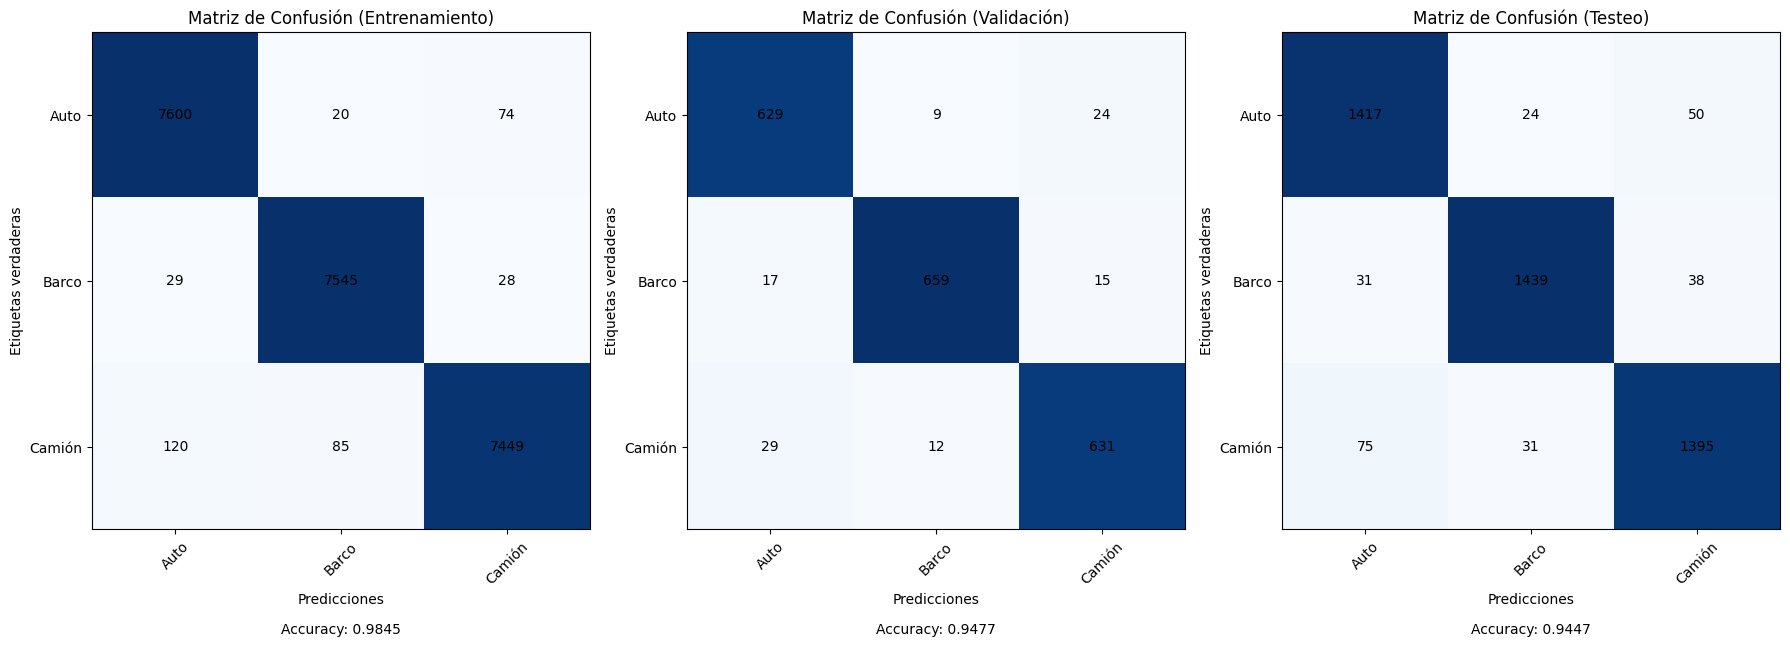

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

# Calcular las matrices de confusión para entrenamiento y prueba
confusion_train = confusion_matrix(y_train_final, y_train_pred_labels)
confusion_testeo = confusion_matrix(y_test_final, y_test_pred_labels)
if include_validation:
  confusion_valid = confusion_matrix(y_validation_final, y_validation_pred_labels)

# Función para mostrar una matriz de confusión en un gráfico con los números y las etiquetas de clase
def plot_confusion_matrix(matrix, title, accuracy, labels, ax):
    im = ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(title)
    # Puedo mostrar una barrita de color al costado, pero queda feo
    # ax.figure.colorbar(im, ax=ax)
    tick_marks = np.arange(len(labels))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Predicciones')
    ax.set_ylabel('Etiquetas verdaderas')
    ax.text(0.5, -0.2, f'Accuracy: {accuracy:.4f}', ha='center', va='center', transform=ax.transAxes)

    # Agregar números en las celdas de la matriz
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, str(matrix[i, j]), ha='center', va='center', color='black')

# Obtener etiquetas únicas
labels = unique_labels(y_train_final)

# Crear una figura con dos subplots en una fila si no hay validación
if include_validation:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    # Mostrar las matrices de confusión en los subplots
    plot_confusion_matrix(confusion_train, "Matriz de Confusión (Entrenamiento)", train_accuracy, class_names, ax1)
    plot_confusion_matrix(confusion_valid, "Matriz de Confusión (Validación)", valid_accuracy, class_names, ax2)
    plot_confusion_matrix(confusion_testeo, "Matriz de Confusión (Testeo)", test_accuracy, class_names, ax3)
else:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # Mostrar solo las matrices de confusión de entrenamiento y prueba
    plot_confusion_matrix(confusion_train, "Matriz de Confusión (Entrenamiento)", train_accuracy, class_names, ax1)
    plot_confusion_matrix(confusion_testeo, "Matriz de Confusión (Testeo)", test_accuracy, class_names, ax2)

plt.tight_layout()
plt.show()

### *Gráficos de Evolución de Métricas*

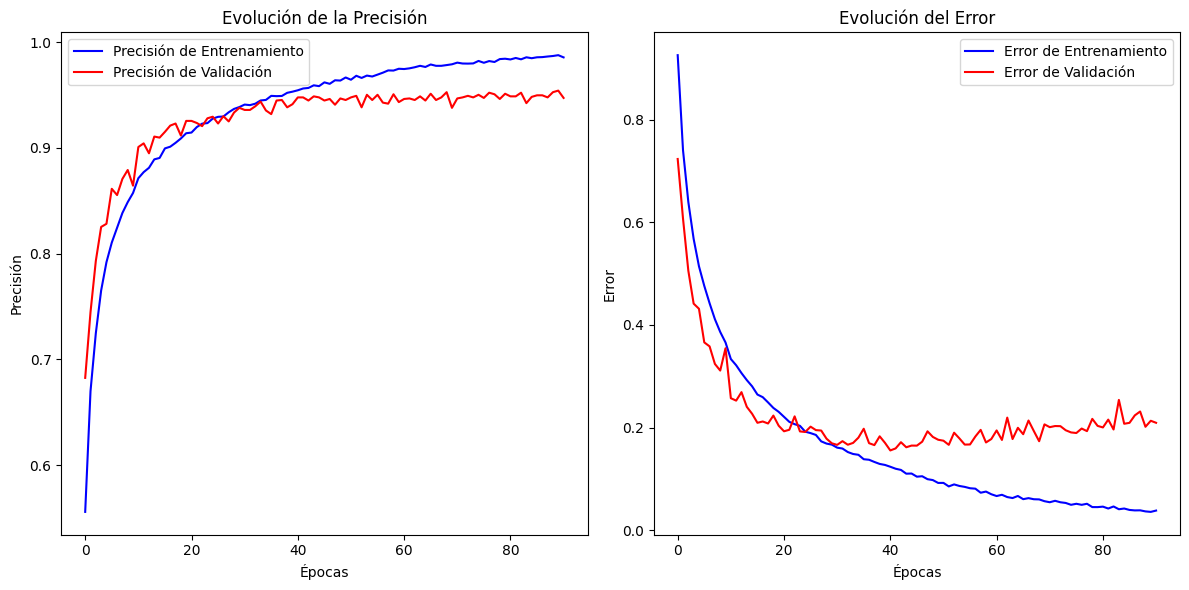

In [71]:
import matplotlib.pyplot as plt

# Obtener las métricas de entrenamiento que guardé en la variable de fiteo
train_loss = fiteo.history['loss']
train_accuracy = fiteo.history['accuracy']

# Crear una figura con dos subplots, uno al lado del otro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico de evolución de la precisión y el error en el subplot izquierdo
ax1.plot(train_accuracy, 'b', label='Precisión de Entrenamiento')
ax1.set_title('Evolución de la Precisión')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Precisión')
ax1.legend()

ax2.plot(train_loss, 'b', label='Error de Entrenamiento')
ax2.set_title('Evolución del Error')
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Error')
ax2.legend()

# Verificar si include_validation es True
if include_validation and 'val_accuracy' in fiteo.history:
    validation_accuracy = fiteo.history['val_accuracy']
    validation_loss = fiteo.history['val_loss']

    # Agregar las métricas de validación al gráfico si están disponibles
    ax1.plot(validation_accuracy, 'r', label='Precisión de Validación')
    ax2.plot(validation_loss, 'r', label='Error de Validación')

    # Agregar leyendas para las métricas de validación
    ax1.legend()
    ax2.legend()

plt.tight_layout()
plt.show()

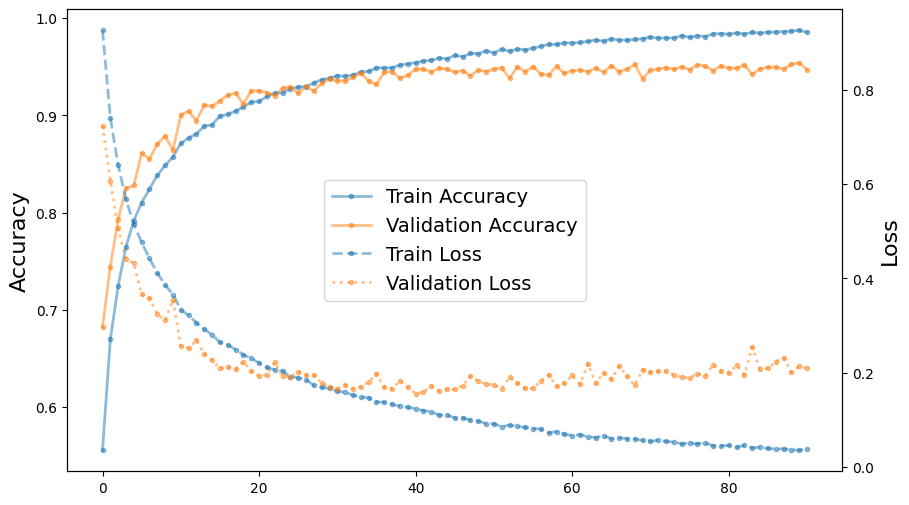

In [72]:
import matplotlib.pyplot as plt

# Gráfico más claro
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

kw = {'marker': '.', 'lw': 2, 'alpha': 0.5}
l0, = ax.plot(fiteo.history['accuracy'], label='Train Accuracy', **kw)

# Verificar si hay métricas de validación disponibles
if include_validation:
    l1, = ax.plot(fiteo.history['val_accuracy'], label='Validation Accuracy', **kw)
    ax2 = ax.twinx()
    ll0, = ax2.plot(fiteo.history['loss'], ls='--', color='C0', label='Train Loss', **kw)
    ll1, = ax2.plot(fiteo.history['val_loss'], ls=':', color='C1', label='Validation Loss', **kw)
    ax2.set_ylabel('Loss', fontsize=16)
else:
    ax2 = ax.twinx()
    ll0, = ax2.plot(fiteo.history['loss'], ls='--', color='C0', label='Train Loss', **kw)
    ax2.set_ylabel('Loss', fontsize=16)

ax.set_ylabel('Accuracy', fontsize=16)

# Crear una leyenda para Accuracy y Loss
lines_accuracy = [l0, l1] if include_validation else [l0]
labels_accuracy = [line.get_label() for line in lines_accuracy]
lines_loss = [ll0, ll1] if include_validation else [ll0]
labels_loss = [line.get_label() for line in lines_loss]
ax.legend(lines_accuracy + lines_loss, labels_accuracy + labels_loss, loc='center', fontsize=14)

plt.show()

### *Distribución de probabilidades*
> Para ver qué tan segura estaba la red:

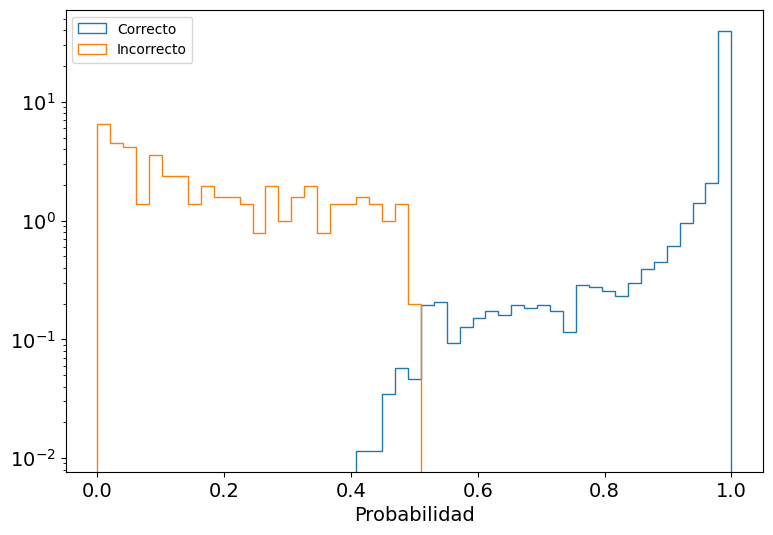

In [73]:
fig = plt.figure(figsize=(9, 6))

# Definir los bins para el histograma
bins = np.linspace(0, 1, 50)

# Histograma de probabilidades en casos correctos
probs_correct = []
for i, (y_true, y_pred) in enumerate(zip(y_test_final, y_test_pred)):
    if y_true == np.argmax(y_pred):
        probs_correct.append(y_pred[y_true])
probs_correct = np.array(probs_correct)
plt.hist(probs_correct, bins=bins, histtype='step', label='Correcto', density=True, log=True)

# Histograma de probabilidades en casos incorrectos
probs_incorrect = []
for i, (y_true, y_pred) in enumerate(zip(y_test_final, y_test_pred)):
    if y_true != np.argmax(y_pred):
        probs_incorrect.append(y_pred[y_true])
probs_incorrect = np.array(probs_incorrect)
plt.hist(probs_incorrect, bins=bins, histtype='step', label='Incorrecto', density=True)

# Etiquetas y marcas
plt.xlabel('Probabilidad', size=14)
plt.gca().tick_params(axis='both', which='major', labelsize=14)

plt.legend(loc=2)
plt.show()

### *Ejemplos de Errores*


Entrenamiento:


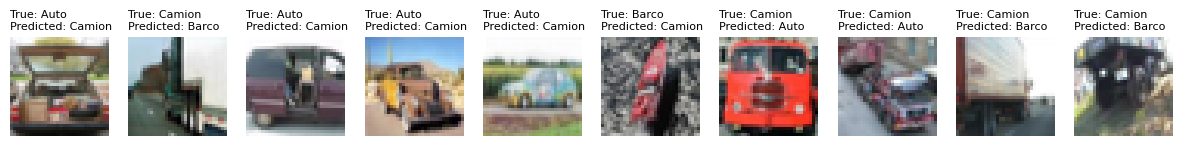

Aciertos en entrenamiento: 22594
Errores en entrenamiento: 356
Testeo:


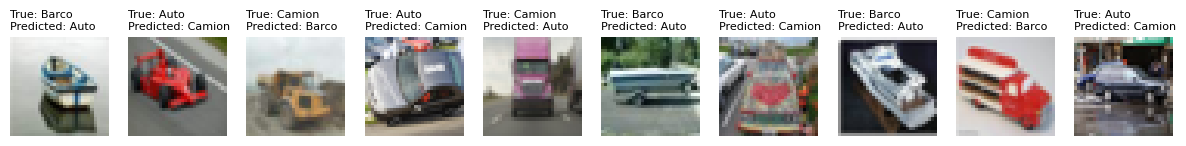

Aciertos en testeo: 4251
Errores en testeo: 249


In [74]:
# Función para contar aciertos y errores
def count_correct_and_errors(true_labels, predicted_labels):
    correct = 0
    errors = 0
    for true_label, predicted_label in zip(true_labels, predicted_labels):
        if true_label == predicted_label:
            correct += 1
        else:
            errors += 1
    return correct, errors

# Contar aciertos y errores en el conjunto de entrenamiento
correct_train, errors_train = count_correct_and_errors(y_train_final, y_train_pred_labels)

# Contar aciertos y errores en el conjunto de prueba
correct_testeo, errors_testeo = count_correct_and_errors(y_test_final, y_test_pred_labels)


# Función que imprime las imágenes con el nombre de clase
def display_images_with_labels(images, true_labels, predicted_labels, num_images=10):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        true_label = "Auto" if true_labels[i] == 0 else ("Barco" if true_labels[i] == 1 else "Camion")
        predicted_label = "Auto" if predicted_labels[i] == 0 else ("Barco" if predicted_labels[i] == 1 else "Camion")
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i])
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}', fontsize=8, loc='left', ha='left')
        plt.axis('off')
    plt.show()

# Encuentra las predicciones incorrectas para el conjunto de entrenamiento
incorrect_predictions_train = [(i, y_true, np.argmax(y_pred)) for i, (y_true, y_pred) in enumerate(zip(y_train_final, y_train_pred)) if y_true != np.argmax(y_pred)]

# Encuentra las predicciones incorrectas para el conjunto de prueba
incorrect_predictions_testeo = [(i, y_true, np.argmax(y_pred)) for i, (y_true, y_pred) in enumerate(zip(y_test_final, y_test_pred)) if y_true != np.argmax(y_pred)]
print()

# Muestra las primeras 10 predicciones incorrectas para entrenamiento
print('Entrenamiento:')
display_images_with_labels(
    [x_train_final[i] for i, _, _ in incorrect_predictions_train[:10]],  # Las primeras 10 imágenes mal clasificadas
    [y_train_final[i] for i, _, _ in incorrect_predictions_train[:10]],  # Las etiquetas verdaderas de esas imágenes
    [pred for _, _, pred in incorrect_predictions_train[:10]]  # Las predicciones del modelo
)
print(f"Aciertos en entrenamiento: {correct_train}")
print(f"Errores en entrenamiento: {errors_train}")

print('=====================================')

print('Testeo:')
# Muestra las primeras 10 predicciones incorrectas para prueba
display_images_with_labels(
    [x_test_final[i] for i, _, _ in incorrect_predictions_testeo[:10]],  # Las primeras 10 imágenes mal clasificadas
    [y_test_final[i] for i, _, _ in incorrect_predictions_testeo[:10]],  # Las etiquetas verdaderas de esas imágenes
    [pred for _, _, pred in incorrect_predictions_testeo[:10]]  # Las predicciones del modelo
)
print(f"Aciertos en testeo: {correct_testeo}")
print(f"Errores en testeo: {errors_testeo}")

## Tablas de Predicciones

In [75]:
import pandas as pd
from tabulate import tabulate
import warnings

# Etiquetas reales de entrenamiento, prueba y validación
y_train = y_train_final
y_test = y_test_final
y_validation = y_validation_final

# Crear un DataFrame para almacenar las estadísticas por clase y conjunto
class_stats = pd.DataFrame(index=class_names, columns=['Cantidad en Entrenamiento', 'Cantidad en Validación', 'Cantidad en Testeo', 'Total'])

# Calcular la cantidad en el conjunto de entrenamiento, validación y prueba por clase
for i, class_name in enumerate(class_names):
    train_mask = y_train == i
    validation_mask = y_validation == i
    test_mask = y_test == i
    class_stats.at[class_name, 'Cantidad en Entrenamiento'] = sum(train_mask)

    # Verificar si hay métricas de validación disponibles
    if include_validation:
        class_stats.at[class_name, 'Cantidad en Validación'] = sum(validation_mask)
    else:
        class_stats.at[class_name, 'Cantidad en Validación'] = 0

    class_stats.at[class_name, 'Cantidad en Testeo'] = sum(test_mask)

    class_stats.at[class_name, 'Total'] = sum(train_mask) + (sum(validation_mask) if include_validation else 0) + sum(test_mask)

# Convertir los valores a enteros y eliminar los corchetes [ ]
class_stats = class_stats.astype({'Cantidad en Entrenamiento': int, 'Cantidad en Validación': int, 'Cantidad en Testeo': int})

# Calcular los totales en la primera tabla
total_entrenamiento = class_stats['Cantidad en Entrenamiento'].sum()
total_validacion = class_stats['Cantidad en Validación'].sum()
total_testeo = class_stats['Cantidad en Testeo'].sum()

# Agregar los totales en la primera tabla
class_stats.loc['Total'] = [total_entrenamiento, total_validacion, total_testeo, total_entrenamiento + total_validacion + total_testeo]

# Desactivar las advertencias específicas que se están generando
warnings.filterwarnings("ignore", message="elementwise comparison failed; returning scalar instead")

# Convertir la tabla de estadísticas a un formato tabular con ancho de 80 caracteres
table = tabulate(class_stats, headers='keys', tablefmt='pretty', numalign='center', stralign='center', colalign=("center",))

# Imprimir la tabla formateada
print('Info del dataset:')
print(table)

# Función para calcular el porcentaje
def calculate_percentage(correct, incorrect):
    total = correct + incorrect
    if total == 0:
        return 0.0
    return (correct / total) * 100.0

# Calcular la cantidad de predicciones correctas e incorrectas por clase en los tres conjuntos
correct_train_per_class = [confusion_train[i, i] for i in range(len(class_names))]
incorrect_train_per_class = [sum(confusion_train[i, :]) - confusion_train[i, i] for i in range(len(class_names))]

correct_valid_per_class = [confusion_valid[i, i] for i in range(len(class_names))]
incorrect_valid_per_class = [sum(confusion_valid[i, :]) - confusion_valid[i, i] for i in range(len(class_names))]

correct_testeo_per_class = [confusion_testeo[i, i] for i in range(len(class_names))]
incorrect_testeo_per_class = [sum(confusion_testeo[i, :]) - confusion_testeo[i, i] for i in range(len(class_names))]

# Crear listas de listas para las tablas de los tres conjuntos
train_table_data = []
valid_table_data = []
testeo_table_data = []

for class_name, correct_count, incorrect_count in zip(class_names, correct_train_per_class, incorrect_train_per_class):
    train_percentage = calculate_percentage(correct_count, incorrect_count)
    train_table_data.append([class_name, correct_count, incorrect_count, f"{train_percentage:.2f}%"])

for class_name, correct_count, incorrect_count in zip(class_names, correct_valid_per_class, incorrect_valid_per_class):
    valid_percentage = calculate_percentage(correct_count, incorrect_count)
    valid_table_data.append([class_name, correct_count, incorrect_count, f"{valid_percentage:.2f}%"])

for class_name, correct_count, incorrect_count in zip(class_names, correct_testeo_per_class, incorrect_testeo_per_class):
    testeo_percentage = calculate_percentage(correct_count, incorrect_count)
    testeo_table_data.append([class_name, correct_count, incorrect_count, f"{testeo_percentage:.2f}%"])

# Agregar una fila con la suma de cada columna en las tablas de predicciones
train_table_data.append(['Total', sum(correct_train_per_class), sum(incorrect_train_per_class), ''])
valid_table_data.append(['Total', sum(correct_valid_per_class), sum(incorrect_valid_per_class), ''])
testeo_table_data.append(['Total', sum(correct_testeo_per_class), sum(incorrect_testeo_per_class), ''])

# Calcular los porcentajes de aciertos en los totales
total_aciertos_train = calculate_percentage(sum(correct_train_per_class), sum(incorrect_train_per_class))
total_aciertos_valid = calculate_percentage(sum(correct_valid_per_class), sum(incorrect_valid_per_class))
total_aciertos_testeo = calculate_percentage(sum(correct_testeo_per_class), sum(incorrect_testeo_per_class))

# Agregar los porcentajes de aciertos en la fila de Totales de las tablas de predicciones
train_table_data[-1][-1] = f"{total_aciertos_train:.2f}%"
valid_table_data[-1][-1] = f"{total_aciertos_valid:.2f}%"
testeo_table_data[-1][-1] = f"{total_aciertos_testeo:.2f}%"

# Imprimir las tablas formateadas para los tres conjuntos
table_headers = ["Clase", "Predicciones Correctas", "Predicciones Incorrectas", "Porcentaje de Aciertos"]

def print_table(title, data):
    print(title)
    table = tabulate(data, headers=table_headers, tablefmt='pretty', numalign='center', stralign='center', colalign=("center", "center", "center", "center"))
    print(table)

print_table("Tabla de Predicciones (Entrenamiento):", train_table_data)
if include_validation:
    print_table("Tabla de Predicciones (Validación):", valid_table_data)
print_table("Tabla de Predicciones (Testeo):", testeo_table_data)

Info del dataset:
+--------+---------------------------+------------------------+--------------------+--------+
|        | Cantidad en Entrenamiento | Cantidad en Validación | Cantidad en Testeo | Total  |
+--------+---------------------------+------------------------+--------------------+--------+
|  Auto  |           7694            |          662           |        1491        | [9847] |
| Barco  |           7602            |          691           |        1508        | [9801] |
| Camión |           7654            |          672           |        1501        | [9827] |
| Total  |           22950           |          2025          |        4500        | 29475  |
+--------+---------------------------+------------------------+--------------------+--------+
Tabla de Predicciones (Entrenamiento):
+--------+------------------------+--------------------------+------------------------+
| Clase  | Predicciones Correctas | Predicciones Incorrectas | Porcentaje de Aciertos |
+--------+-----